In [11]:
import torch
from torch import nn, optim
from nltk import grammar
from nltk import PCFG, CFG
from nltk.parse import RecursiveDescentParser
import random
import numpy
import matplotlib.pyplot as plt

# Grammars

In [12]:
#following http://www.nltk.org/howto/generate.html

#starts with x, has more ys than zs, ends with z
xyyz_grammar = """
S -> 'x'A'y'A'y'A'z'
A -> | A'y'A'z'A | A'z'A'y'A | 'x'A
"""

#a^n b^m B^m A^n, n,m > 0
abBA_grammar = """
S -> 'a'X'A' [1.0]
X -> 'a'X'A' [0.6] | 'b'Y'B' [0.4]
Y -> [0.1] | 'b'Y'B' [0.9]
"""

In [13]:
#xyyz_cfg = CFG.fromstring(xyyz_grammar)
#print(xyyz_cfg)
abBA_cfg = PCFG.fromstring(abBA_grammar)
print(abBA_cfg)

Grammar with 5 productions (start state = S)
    S -> 'a' X 'A' [1.0]
    X -> 'a' X 'A' [0.6]
    X -> 'b' Y 'B' [0.4]
    Y ->  [0.1]
    Y -> 'b' Y 'B' [0.9]


# Language functions

In [14]:
def sample_grammar(g, var, maxlen=5):
    cond_rules = g.productions(lhs=var)
    probs = [r.prob() for r in cond_rules]
    #sample from production rules
    product = list(random.choices(cond_rules, weights=probs, k=1)[0].rhs())
    substring = []
    finishup = False
    for c in product:
        if len(substring) >= maxlen: #works as a base case
            finishup = True
        if grammar.is_nonterminal(c):
            if not finishup:
                substring.extend(sample_grammar(g, c, maxlen))
        else:
            substring.append(c)
    return substring

def dict_from_grammar(g):
    terminals = set()
    for prod in g.productions():
        terminals = terminals.union(set([c for c in prod.rhs() if grammar.is_terminal(c)]))
    terminals_to_idx = dict()
    idx_to_terminals = dict()
    for i,e in enumerate(terminals, 1):
        terminals_to_idx[e] = i
        idx_to_terminals[i] = e
    terminals_to_idx['T'] = 0 #set end char
    idx_to_terminals[0] = 'T'
    return terminals_to_idx, idx_to_terminals

def index_sequences(seqs, char_to_idx):
    seqs_indexed = []
    for i in range(len(seqs)):
        seqs_indexed.append(torch.LongTensor([char_to_idx[c] for c in seqs[i]]))
    return seqs_indexed

def one_hot_pad(seqs, c):
    """
    Args:
        seqs: list of tensors of size (seq_len,)
        c: num_classes
    Output:
        one_hots: tensor of size (batch_size, max(seq_lens), c)
    """
    seqs = nn.utils.rnn.pad_sequence(seqs, batch_first=True) #(batch_size, max(seq_lens))
    return nn.functional.one_hot(seqs, num_classes=c) 

def sequences_from_grammar(g, checker, maxlen=5, n=512, dn=512):
    #n will often be smaller than desired n, dn
    terminals_to_idx, idx_to_terminals = dict_from_grammar(g)
    strings = []
    lengths = []
    for i in range(n):
        string = ''.join(sample_grammar(g, g.start(), maxlen))
        assert checker(string), print(string)
        strings.append(string)
        lengths.append(len(string))
    strings = list(set(strings))
    print("{} unique strings generated".format((len(strings))))
    strings = strings[:dn]
    one_hots = one_hot_pad(index_sequences(strings, terminals_to_idx), len(terminals_to_idx)).float()
    return strings, one_hots, (terminals_to_idx, idx_to_terminals)

def check_parity(string, a, b):
    a_count = 0
    b_count = 0
    for c in string:
        if c == a:
            a_count += 1
        elif c == b:
            b_count += 1
    if a_count > b_count:
        return 1
    elif a_count < b_count:
        return -1
    else:
        return 0

def abBA_checker(string):
    return check_parity(string, 'a', 'A') == 0 and check_parity(string, 'b', 'B') == 0
    
def xyyz_checker(string):
    return check_parity(string, 'y', 'z') == 1

# Generate data

Randomly generated

In [15]:
abBA_random, abBA_one_hots, (abBA_t2i, abBA_i2t) = sequences_from_grammar(abBA_cfg, abBA_checker, maxlen=10, n=200000)
print(abBA_random[:10])
print(abBA_one_hots.shape)

926 unique strings generated
['abbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBA', 'abbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBA', 'aaaaaaaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBAAAAAAAA', 'aaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBAAAAAAAAAAAAAA', 'aaaaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBAAAAA', 'abbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBA', 'aaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBAAA', 'aaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBAAAAAAAAAAAAAAAA', 'aaaaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBAAAAA', 'aaaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbBBBBBBBBBBBBBBBBBBAAAAAA

Following procedure described in Gers & Schmidhuber

In [16]:
nplusm = 12
abBA_train12 = []
abBA_test12 = []
"""
abBA_sum12 = []
for i in range(1, nplusm):
    j = nplusm-i
    abBA_sum12.append('a'*i + 'b'*j + 'B'*j + 'A'*i)
"""
for i in range(1, 12):
    for j in range(1, 12):
        abBA_train12.append('a'*i + 'b'*j + 'B'*j + 'A'*i)
for i in range(1, 22):
    for j in range(1, 22):
        abBA_test12.append('a'*i + 'b'*j + 'B'*j + 'A'*i)
abBA_train12 = one_hot_pad(index_sequences(abBA_train12, abBA_t2i), len(abBA_t2i)).float()
abBA_test12 = one_hot_pad(index_sequences(abBA_test12, abBA_t2i), len(abBA_t2i)).float()
print(abBA_train12.shape, abBA_test12.shape)

torch.Size([121, 44, 5]) torch.Size([441, 84, 5])


# Model functions

In [17]:
def score(preds, lookup, checker, display=False):
    """
    Not the loss function
    
    Like a binary classification problem: accept/reject,
    accept iff the input is something in the target set.
    Something is not in the target set iff at any time step output isn't.
    """
    results = []
    preds = preds.cpu()
    for i in range(preds.shape[0]):
        idxs = torch.argmax(preds, dim=2)[i].tolist()
        string = ''.join([lookup[idx] for idx in idxs])
        if display:
            print(string)
        results.append(checker(string))
    return results
    
class SequenceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, hc=None):
        if hc == None:
            out, hc = self.lstm(x)
        else:
            out, hc = self.lstm(x, hc)
        return self.logsoftmax(self.fc(out)), hc
    
def train(data, model, optimizer, epochs=10, eval_every=5):
    model = model.to(device)
    loss_function = nn.NLLLoss()
    data = data.to(device)
    inputs = data[:,:-1]
    targets = torch.argmax(data[:,1:], dim=2) #shift sequence forward by 1
    
    epochs_loss = 0
    avg_loss = 1
    e = 0
    while avg_loss > .05 and e <= epochs:
        for i in range(data.shape[0]):
            #feed in 1 sequence at a time, update after every sequence
            #swap axis 1 and 2 since loss function reads class as axis 1 where lstm output has seq_len as axis 1
            loss = loss_function(model(inputs[i].unsqueeze(0))[0].permute(0,2,1), targets[i].unsqueeze(0))
            epochs_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        e += 1
        if e % eval_every == 0:
            avg_loss = epochs_loss / (data.shape[0] * eval_every)
            preds = model(data_test.to(device))[0]
            test_scores = score(preds, abBA_i2t, abBA_checker)
            print("Epoch {} train loss: {}, test score: {:f}".format(e, avg_loss, sum(test_scores)/len(test_scores)))
            epochs_loss = 0

# Train

In [18]:
HIDDEN_UNITS = 2

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: {}".format(device))

"""
Network architecture:
abBA: two blocks w/ one cell each
"""

data_train, data_test = (abBA_train12, abBA_test12) #abBA_one_hots[:256], abBA_one_hots[256:]
model = SequenceModel(len(abBA_t2i), HIDDEN_UNITS, len(abBA_t2i), 1)
optimizer = optim.Adam(model.parameters(), lr=.0001)
train(data_train, model, optimizer, epochs=300, eval_every=50)

Using device: cuda
Epoch 50 train loss: 1.212270731576218, test score: 0.000000
Epoch 100 train loss: 0.7173976056708777, test score: 0.004535
Epoch 150 train loss: 0.5558137488463694, test score: 0.015873
Epoch 200 train loss: 0.4718520883292206, test score: 0.072562
Epoch 250 train loss: 0.4262921187848099, test score: 1.000000
Epoch 300 train loss: 0.39560908722483423, test score: 1.000000


# Analysis

Take a look at internal state representations

In [23]:
model = model.to('cpu')
test_string = 'aaaaabbbbBBBBAAAAA'
test_seq = one_hot_pad(index_sequences([test_string], abBA_t2i), len(abBA_t2i)).float()
cstates = {i:[] for i in range(HIDDEN_UNITS)}
hc_t = (torch.zeros(1, 1, HIDDEN_UNITS), torch.zeros(1, 1, HIDDEN_UNITS))
with torch.no_grad():
    for t in range(test_seq.shape[1]): #feed in one char at a time and get cell state at each time step
        _, hc_t = model.lstm(test_seq[:,t,:].unsqueeze(0), hc_t)
        hidden_t, cstate_t = hc_t
        for i in range(cstate_t.shape[2]): #get state for each hidden unit
            cstates[i].append(cstate_t[:,:,i].squeeze().item())
    print(score(model(test_seq)[0], abBA_i2t, abBA_checker, True))
#score(model(data_test.to(device)), idx_to_terminals, abBA_checker, True)

aaaaabbbbBBBBAAAAA
[True]


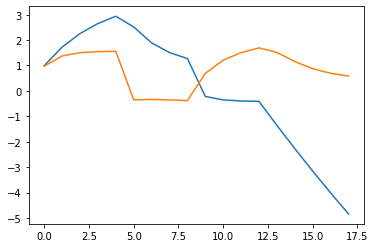

In [24]:
plt.plot(cstates[0])
plt.plot(cstates[1])

In [ ]:
sampled_string = 'a'
char_t = sampled_string
hc_t = (torch.zeros(1, 1, HIDDEN_UNITS), torch.zeros(1, 1, HIDDEN_UNITS))
with torch.no_grad():
    while char_t != 'T':
        in_t = one_hot_pad(index_sequences([char_t], terminals_to_idx), len(terminals_to_idx)).float()
        out_t, hc_t = model(in_t, hc_t)
        probs = torch.exp(out_t).squeeze().tolist()
        char_t = idx_to_terminals[random.choices(range(5), weights=probs)[0]]
        sampled_string += char_t
print(sampled_string, abBA_checker(sampled_string))

# Notes

To do:
Generalize from shorter to longer sequences
Use the output from time step t-1 as x_t

Known to work:
Input and output units same size as # cats, two hidden units with one fc layer. For training, update after every sequence, 40-50 epochs, lr=.001

# Further work

In [ ]:
"""
#Parsing strings
#can't even parse a simple string!
rd = RecursiveDescentParser(xyz_cfg)
for t in rd.parse(list('xyyz')):
    print(t)
    
#Packing sequences
nn.utils.rnn.pack_padded_sequence(seqs, lengths, True, False)

#Weight sizes
[w.nelement() for _, w  in model.state_dict().items()]
"""